# Wolt Data Science Internship Test

Hello everyone! My name is Anastasiia Murashova and I am ready to present my skills in data science to Wolt. Today I am presenting to you my analysis of dataset with food orders

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
orders_df = pd.read_csv('orders_autumn_2020.csv')

## EDA

In [3]:
orders_df

TIMESTAMP  \
0      2020-08-01 06:07:00.000   
1      2020-08-01 06:17:00.000   
2      2020-08-01 06:54:00.000   
3      2020-08-01 07:09:00.000   
4      2020-08-01 07:10:00.000   
...                        ...   
18701  2020-09-30 19:27:00.000   
18702  2020-09-30 19:36:00.000   
18703  2020-09-30 19:39:00.000   
18704  2020-09-30 19:42:00.000   
18705  2020-09-30 20:04:00.000   

       ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES  ITEM_COUNT  \
0                                                    -19              1   
1                                                     -7              8   
2                                                    -17              4   
3                                                     -2              3   
4                                                     -1              2   
...                                                  ...            ...   
18701                                                 -1              1   
18702                                                 -8              6   
18703                                                -14              3   
18704                                                -11              3   
18705                                                 -7              1   

       USER_LAT  USER_LONG  VENUE_LAT  VENUE_LONG  ESTIMATED_DELIVERY_MINUTES  \
0        60.158     24.946     60.160      24.946                          29   
1        60.163     24.927     60.153      24.910                          39   
2        60.161     24.937     60.162      24.939                          23   
3        60.185     24.954     60.190      24.911                          28   
4        60.182     24.955     60.178      24.949                          27   
...         ...        ...        ...         ...                         ...   
18701    60.170     24.946     60.170      24.945                          24   
18702    60.185     24.944     60.178      24.949                          23   
18703    60.186     24.949     60.188      24.956                          25   
18704    60.172     24.929     60.168      24.930                          21   
18705    60.166     24.965     60.183      24.951                          28   

       ACTUAL_DELIVERY_MINUTES  CLOUD_COVERAGE  TEMPERATURE  WIND_SPEED  \
0                           10             0.0         15.0     3.53644   
1                           32             0.0         15.0     3.53644   
2                            6             0.0         15.0     3.53644   
3                           26             0.0         16.7     3.52267   
4                           26             0.0         16.7     3.52267   
...                        ...             ...          ...         ...   
18701                       23             0.0         12.8     2.34419   
18702                       15             0.0         12.8     2.34419   
18703                       11             0.0         12.8     2.34419   
18704                       10             0.0         12.8     2.34419   
18705                       21             0.0         12.8     2.34249   

       PRECIPITATION  
0                0.0  
1                0.0  
2                0.0  
3                0.0  
4                0.0  
...              ...  
18701            0.0  
18702            0.0  
18703            0.0  
18704            0.0  
18705            0.0  

[18706 rows x 13 columns]

Here we parse timestamps to make separate columns with days, months and day of the week, it allows us to make new features for further analysis

In [4]:
orders_df['TIMESTAMP'] = pd.to_datetime(orders_df['TIMESTAMP'])
orders_df['day'] = orders_df['TIMESTAMP'].dt.day
orders_df['month'] = orders_df['TIMESTAMP'].dt.month
orders_df['weekday'] = orders_df['TIMESTAMP'].dt.day_of_week

Here we can see the dataset with info about food orders in Wolt for period from 1 August to 30 September 2020, simply two months. Columns tell us that we have timestamps, including milliseconds, difference between actual and estimated delivery times in absolute values, number of items in the package, coordinates of the client and the place from where the client indicates food (width and longitude), estimated and actual delivery time in the shortest possible time and weather, where is the percentage of cloud cover, air temperature, wind speed, degree of precipitation.

In [5]:
orders_df.describe()

TIMESTAMP  \
count                          18706   
mean   2020-09-01 12:20:11.697851136   
min              2020-08-01 06:07:00   
25%              2020-08-16 19:48:00   
50%              2020-09-02 11:07:00   
75%              2020-09-16 16:40:45   
max              2020-09-30 20:04:00   
std                              NaN   

       ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES    ITEM_COUNT  \
count                                       18706.000000     18706.000000   
mean                                           -1.201058         2.688228   
min                                           -41.000000         1.000000   
25%                                            -7.000000         1.000000   
50%                                            -2.000000         2.000000   
75%                                             5.000000         4.000000   
max                                            34.000000        11.000000   
std                                             8.979834         1.886455   

           USER_LAT     USER_LONG     VENUE_LAT    VENUE_LONG  \
count  18706.000000  18706.000000  18706.000000  18706.000000   
mean      60.175234     24.941244     60.175643     24.941214   
min       60.153000     24.909000     60.149000     24.878000   
25%       60.163000     24.926000     60.167000     24.930000   
50%       60.175000     24.943000     60.170000     24.941000   
75%       60.186000     24.954000     60.186000     24.950000   
max       60.201000     24.980000     60.219000     25.042000   
std        0.012674      0.016540      0.011509      0.014482   

       ESTIMATED_DELIVERY_MINUTES  ACTUAL_DELIVERY_MINUTES  CLOUD_COVERAGE  \
count                18706.000000             18706.000000    18429.000000   
mean                    33.809313                32.608254       11.996853   
min                     10.000000                 6.000000        0.000000   
25%                     28.000000                25.000000        0.000000   
50%                     33.000000                32.000000        0.000000   
75%                     38.000000                40.000000       25.000000   
max                     82.000000                58.000000      100.000000   
std                      7.340283                10.018879       23.812605   

        TEMPERATURE    WIND_SPEED  PRECIPITATION           day         month  \
count  18429.000000  18429.000000   18706.000000  18706.000000  18706.000000   
mean      16.973536      3.790991       0.332756     15.990271      8.515022   
min        6.100000      0.077419       0.000000      1.000000      8.000000   
25%       14.400000      2.696190       0.000000      9.000000      8.000000   
50%       16.700000      3.631970       0.000000     16.000000      9.000000   
75%       18.900000      4.692530       0.000000     23.000000      9.000000   
max       26.700000      9.857300       6.315790     31.000000      9.000000   
std        3.411900      1.456017       1.129234      8.674056      0.499788   

            weekday  
count  18706.000000  
mean       3.289533  
min        0.000000  
25%        2.000000  
50%        4.000000  
75%        5.000000  
max        6.000000  
std        2.020265

Here we calculate correlation among all the features

In [6]:
corr = abs(orders_df.corr())
corr.style.background_gradient(cmap="Blues", axis=1)\
    .format(precision=1)

### Location analysis

Here we analyse geopositions of our users and venues

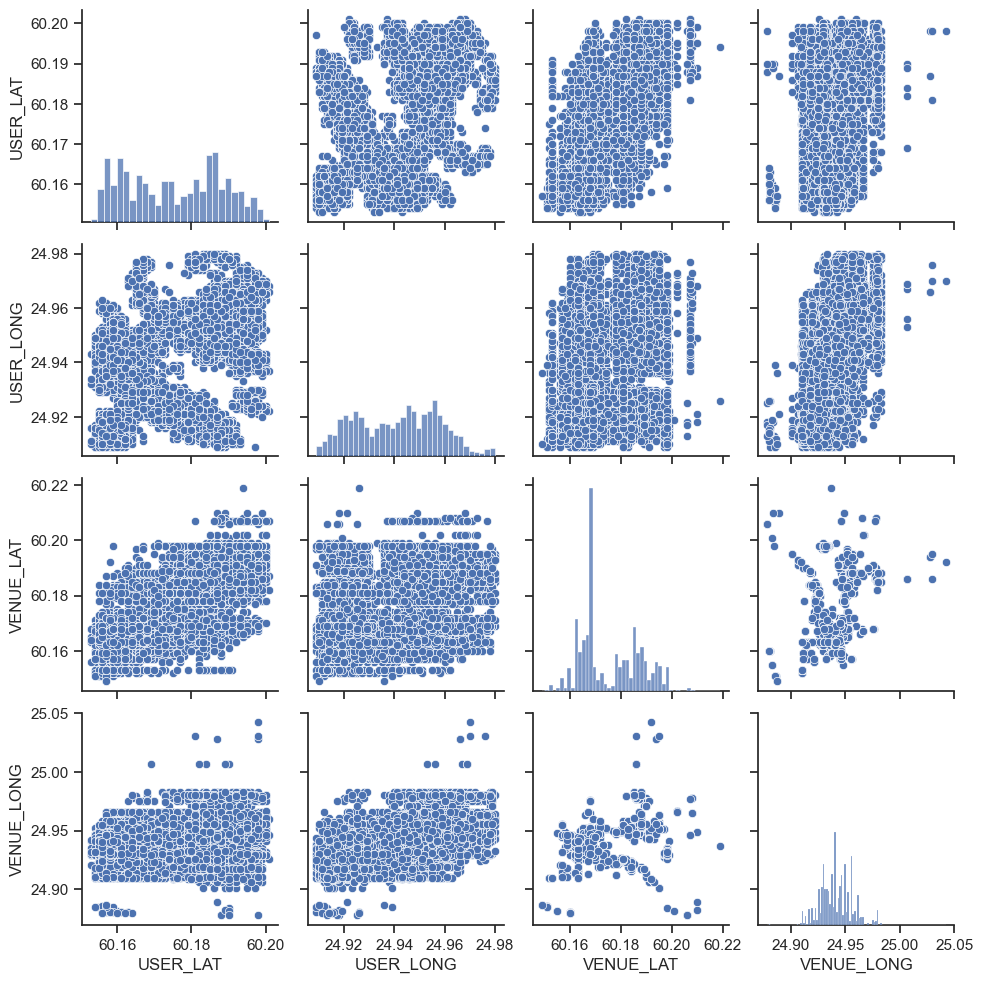

In [7]:
geo_cols = ['USER_LAT', 'USER_LONG', 'VENUE_LAT', 'VENUE_LONG']

sns.set_theme(style="ticks")
sns.pairplot(orders_df[geo_cols])

Based on this description, we explore clients and venues in central disctricts of Helsinki, west-east from Ruoholahti to Kalasatama, south-north from Ulanlinna to Pasila. There is from 1 to 11 items in each order, no more than 34 delay and even 41 minute's occaison of speed boost of delivery

At the distributions we see peaks and troughs: according to the coordinates of clients and establishments, this can be explained by the railway tracks passing approximately in the middle of the coordinate range we specified, and that means that people cannot live and work on the railway tracks themselves

Let's take a look at approximate geolocation distribution of the fastest orders

In [8]:
orders_df_fast = orders_df.query('ACTUAL_DELIVERY_MINUTES < 30')

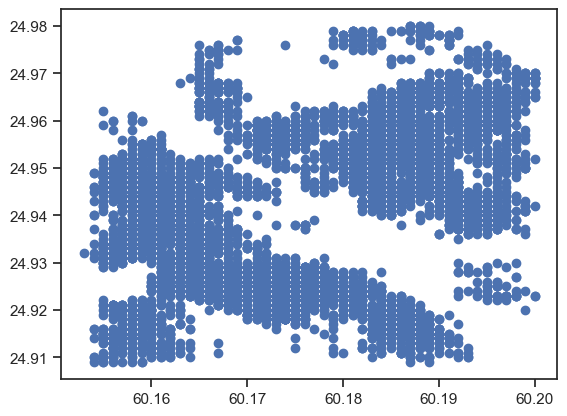

In [9]:
plt.scatter(orders_df_fast.USER_LAT, orders_df_fast.USER_LONG)

As wee see by the dates and temperatures, it is August and September, end of summer, enough quiet season in Finland with average temp ~17 degrees

Let's analyse users activity by days of month and week

<Axes: title={'center': 'day of the week'}>

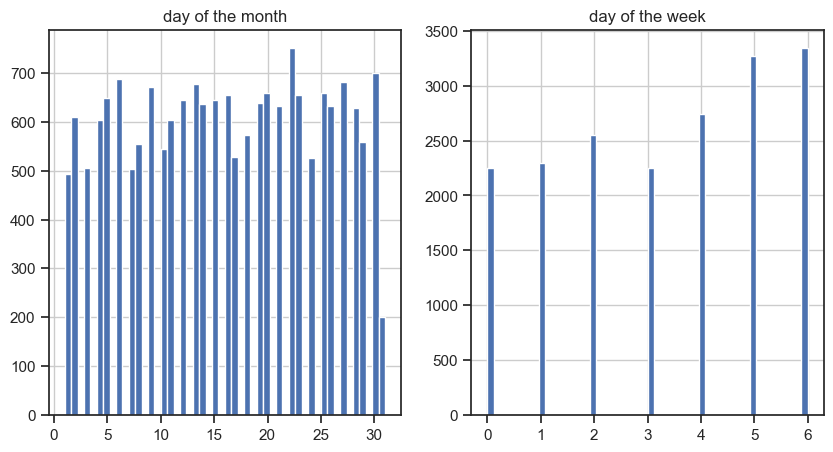

In [10]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('day of the month')
orders_df.day.hist(bins=50)
plt.subplot(1, 2, 2)
plt.title('day of the week')
orders_df.weekday.hist(bins=50)

Orders are approximately spreaded in the months, but we see significant rising of quantity of orders from the middle till the end of the week

Time to make target analysis, which we will use in model approach and prognose building

<Axes: >

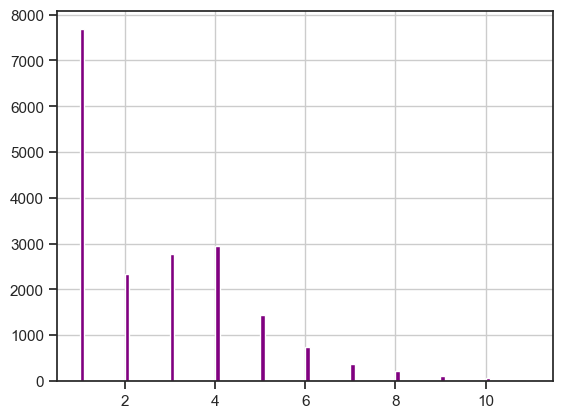

In [11]:
orders_df.ITEM_COUNT.hist(bins=100, color='purple')

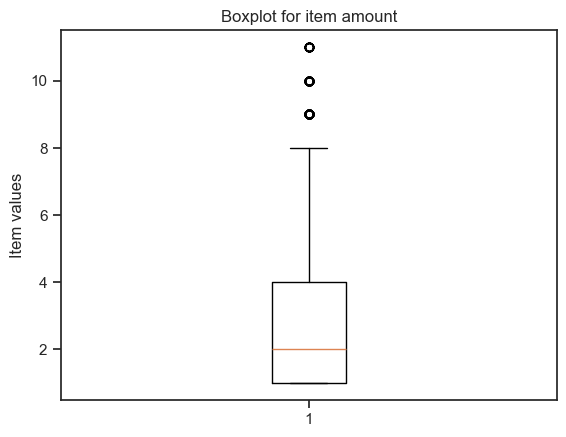

In [12]:
plt.boxplot(orders_df.ITEM_COUNT)
plt.ylabel('Item values')
plt.title('Boxplot for item amount')
plt.show()

Both histogram and boxplot comfirm that majority of clients ordres 1 or rare 2 positions, less than 75% orders contains 4 positions and items from 9 to 11 in an order are exclusion

Next, we need to understand the missing data

In [13]:
cloud_nan = pd.isnull(orders_df['CLOUD_COVERAGE'])

# filtering and displaying data only with NaN by cloud coverage
orders_df[cloud_nan]

TIMESTAMP  \
11778 2020-09-10 06:22:00   
11779 2020-09-10 06:29:00   
11780 2020-09-10 06:31:00   
11781 2020-09-10 06:38:00   
11782 2020-09-10 07:00:00   
...                   ...   
12050 2020-09-10 18:56:00   
12051 2020-09-10 19:07:00   
12052 2020-09-10 19:09:00   
12053 2020-09-10 19:43:00   
12054 2020-09-10 19:55:00   

       ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES  ITEM_COUNT  \
11778                                                 -1              2   
11779                                                  4              1   
11780                                                  1              2   
11781                                                 -7              2   
11782                                                  7              2   
...                                                  ...            ...   
12050                                                -10              4   
12051                                                  4              1   
12052                                                 11              6   
12053                                                 -7              2   
12054                                                -13              1   

       USER_LAT  USER_LONG  VENUE_LAT  VENUE_LONG  ESTIMATED_DELIVERY_MINUTES  \
11778    60.175     24.922     60.179      24.922                          21   
11779    60.159     24.944     60.162      24.939                          22   
11780    60.162     24.926     60.168      24.938                          25   
11781    60.161     24.937     60.168      24.930                          23   
11782    60.170     24.956     60.178      24.949                          30   
...         ...        ...        ...         ...                         ...   
12050    60.172     24.956     60.178      24.949                          34   
12051    60.178     24.929     60.168      24.930                          23   
12052    60.156     24.932     60.168      24.930                          23   
12053    60.160     24.936     60.168      24.939                          26   
12054    60.187     24.953     60.190      24.956                          25   

       ACTUAL_DELIVERY_MINUTES  CLOUD_COVERAGE  TEMPERATURE  WIND_SPEED  \
11778                       20             NaN          NaN         NaN   
11779                       26             NaN          NaN         NaN   
11780                       26             NaN          NaN         NaN   
11781                       16             NaN          NaN         NaN   
11782                       37             NaN          NaN         NaN   
...                        ...             ...          ...         ...   
12050                       24             NaN          NaN         NaN   
12051                       27             NaN          NaN         NaN   
12052                       34             NaN          NaN         NaN   
12053                       19             NaN          NaN         NaN   
12054                       12             NaN          NaN         NaN   

       PRECIPITATION  day  month  weekday  
11778            0.0   10      9        3  
11779            0.0   10      9        3  
11780            0.0   10      9        3  
11781            0.0   10      9        3  
11782            0.0   10      9        3  
...              ...  ...    ...      ...  
12050            0.0   10      9        3  
12051            0.0   10      9        3  
12052            0.0   10      9        3  
12053            0.0   10      9        3  
12054            0.0   10      9        3  

[277 rows x 16 columns]

We see, that there's only one day of missing data, for 10th September 2020, approximately 1,5% of data, and cloud coverage matching with temperature and wind speed

Exploring correlation and dispersion by what data looks like in the absence of weather data

In [14]:
x = orders_df[cloud_nan]['ACTUAL_DELIVERY_MINUTES']
y = orders_df[cloud_nan]['ESTIMATED_DELIVERY_MINUTES']

Correlation coefficient: 0.4575086479358364


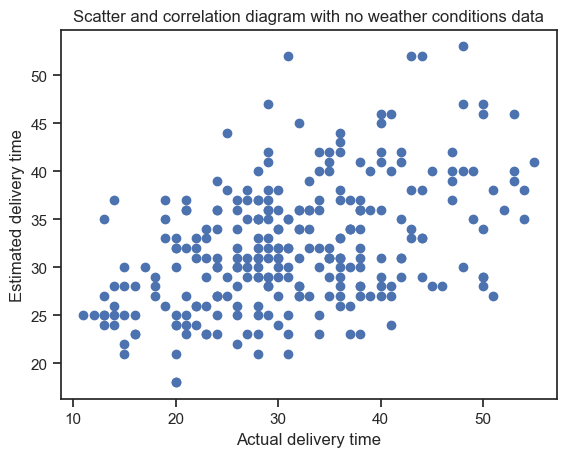

In [15]:
# Calculating Pearson's correlation coefficient
correlation = np.corrcoef(x, y)[0, 1]
print("Correlation coefficient:", correlation)

# Data visualization
plt.scatter(x, y)
plt.xlabel('Actual delivery time')
plt.ylabel('Estimated delivery time')
plt.title('Scatter and correlation diagram with no weather conditions data')
plt.show()

The low correlation coefficient of 0.475 suggests that the estimated and actual delivery times are not particularly dependent on each other based on the small amount of data that we have. Let's see how this compares in the graphs with all the data

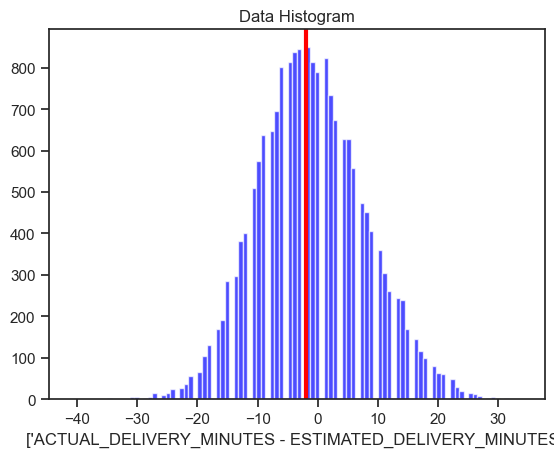

Correlation coefficient: 0.5005362278988063


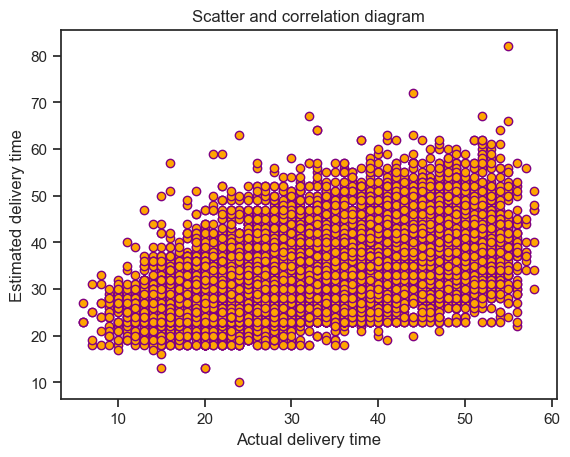

In [16]:
# Histogram building
plt.hist(orders_df['ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES'], bins=100, color='blue', alpha=0.7)
plt.xlabel(['ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES'])
plt.axvline(x=orders_df['ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES'].median(), color='red', linewidth=3)
plt.title('Data Histogram')
plt.show()


# Scatter and correlation diagram building
x = orders_df['ACTUAL_DELIVERY_MINUTES']
y = orders_df['ESTIMATED_DELIVERY_MINUTES']

correlation = np.corrcoef(x, y)[0, 1]
print("Correlation coefficient:", correlation)

plt.scatter(x, y, color='orange', edgecolors= 'purple')
plt.xlabel('Actual delivery time')
plt.ylabel('Estimated delivery time')
plt.title('Scatter and correlation diagram')
plt.show()

### EDA conclusion

This histogram captures that we have a normal distribution between actual and real delivery times, with the peak values being between -10 and 0 minutes, which tells us that the median value of the estimated time is higher than the actual time spent on delivery. This can indicate high customer satisfaction and subsequent loyalty. The scatterplot confirms the data from the histogram with its clustering of data, linearly dependent on actual and planned delivery times with a small number of outliers

## Clusterization

Let's explore our data through clusterization, to check if we can find defined groups by some criteria. For example, I take info about user and venue locations and actual and estimated delivery time. Does this everything correlating?

In [17]:
paiplot_cols = ['USER_LAT', 'USER_LONG', 'VENUE_LAT', 'VENUE_LONG', 'ESTIMATED_DELIVERY_MINUTES', 'ACTUAL_DELIVERY_MINUTES', 'day', 'month', 'weekday']

In [18]:
pairplot_df = orders_df[paiplot_cols]

Looking at all correlations and excluding highly mutually correlated features, they won't be used in clusterization

In [19]:
corr = abs(pairplot_df.corr())
corr.style.background_gradient(cmap="Blues", axis=1)\
    .format(precision=1)

As we see that latitudes of users and venues highly correlated, we take only one of them for further analysis

In [20]:
pairplot_df = pairplot_df.drop(columns=['VENUE_LAT'])

In [21]:
# loading data preprocessing library
# this library will calibrate data to normal values automatically
from sklearn import preprocessing
dataNorm = preprocessing.MinMaxScaler().fit_transform(pairplot_df.values)

In [22]:
dataNorm.shape

(18706, 8)

In [23]:
dataNorm

array([[0.10416667, 0.52112676, 0.41463415, ..., 0.        , 0.        ,
        0.83333333],
       [0.20833333, 0.25352113, 0.19512195, ..., 0.        , 0.        ,
        0.83333333],
       [0.16666667, 0.3943662 , 0.37195122, ..., 0.        , 0.        ,
        0.83333333],
       ...,
       [0.6875    , 0.56338028, 0.47560976, ..., 0.96666667, 1.        ,
        0.33333333],
       [0.39583333, 0.28169014, 0.31707317, ..., 0.96666667, 1.        ,
        0.33333333],
       [0.27083333, 0.78873239, 0.44512195, ..., 0.96666667, 1.        ,
        0.33333333]])

We received a series of normalized data with the coordinates of users, venues, estimated and actual delivery times.
Let's now look at the correlation between them

In [24]:
# Let's make DBSACN clasterization and label our data depending by amount of clusters

db = DBSCAN(eps=0.3, min_samples=10).fit(dataNorm)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 2
Estimated number of noise points: 23


In [25]:
pairplot_df['label'] = labels

In [26]:
abs(pairplot_df.corr())

USER_LAT  USER_LONG  VENUE_LONG  \
USER_LAT                    1.000000   0.327151    0.344495   
USER_LONG                   0.327151   1.000000    0.604920   
VENUE_LONG                  0.344495   0.604920    1.000000   
ESTIMATED_DELIVERY_MINUTES  0.053572   0.011572    0.000506   
ACTUAL_DELIVERY_MINUTES     0.032420   0.001571    0.012243   
day                         0.001343   0.000810    0.004300   
month                       0.004407   0.007191    0.013340   
weekday                     0.013543   0.008243    0.002760   
label                       0.003103   0.008467    0.011772   

                            ESTIMATED_DELIVERY_MINUTES  \
USER_LAT                                      0.053572   
USER_LONG                                     0.011572   
VENUE_LONG                                    0.000506   
ESTIMATED_DELIVERY_MINUTES                    1.000000   
ACTUAL_DELIVERY_MINUTES                       0.500536   
day                                           0.055550   
month                                         0.116348   
weekday                                       0.024458   
label                                         0.121478   

                            ACTUAL_DELIVERY_MINUTES       day     month  \
USER_LAT                                   0.032420  0.001343  0.004407   
USER_LONG                                  0.001571  0.000810  0.007191   
VENUE_LONG                                 0.012243  0.004300  0.013340   
ESTIMATED_DELIVERY_MINUTES                 0.500536  0.055550  0.116348   
ACTUAL_DELIVERY_MINUTES                    1.000000  0.035533  0.103179   
day                                        0.035533  1.000000  0.025666   
month                                      0.103179  0.025666  1.000000   
weekday                                    0.013684  0.016024  0.045395   
label                                      0.107084  0.025223  0.993418   

                             weekday     label  
USER_LAT                    0.013543  0.003103  
USER_LONG                   0.008243  0.008467  
VENUE_LONG                  0.002760  0.011772  
ESTIMATED_DELIVERY_MINUTES  0.024458  0.121478  
ACTUAL_DELIVERY_MINUTES     0.013684  0.107084  
day                         0.016024  0.025223  
month                       0.045395  0.993418  
weekday                     1.000000  0.044567  
label                       0.044567  1.000000

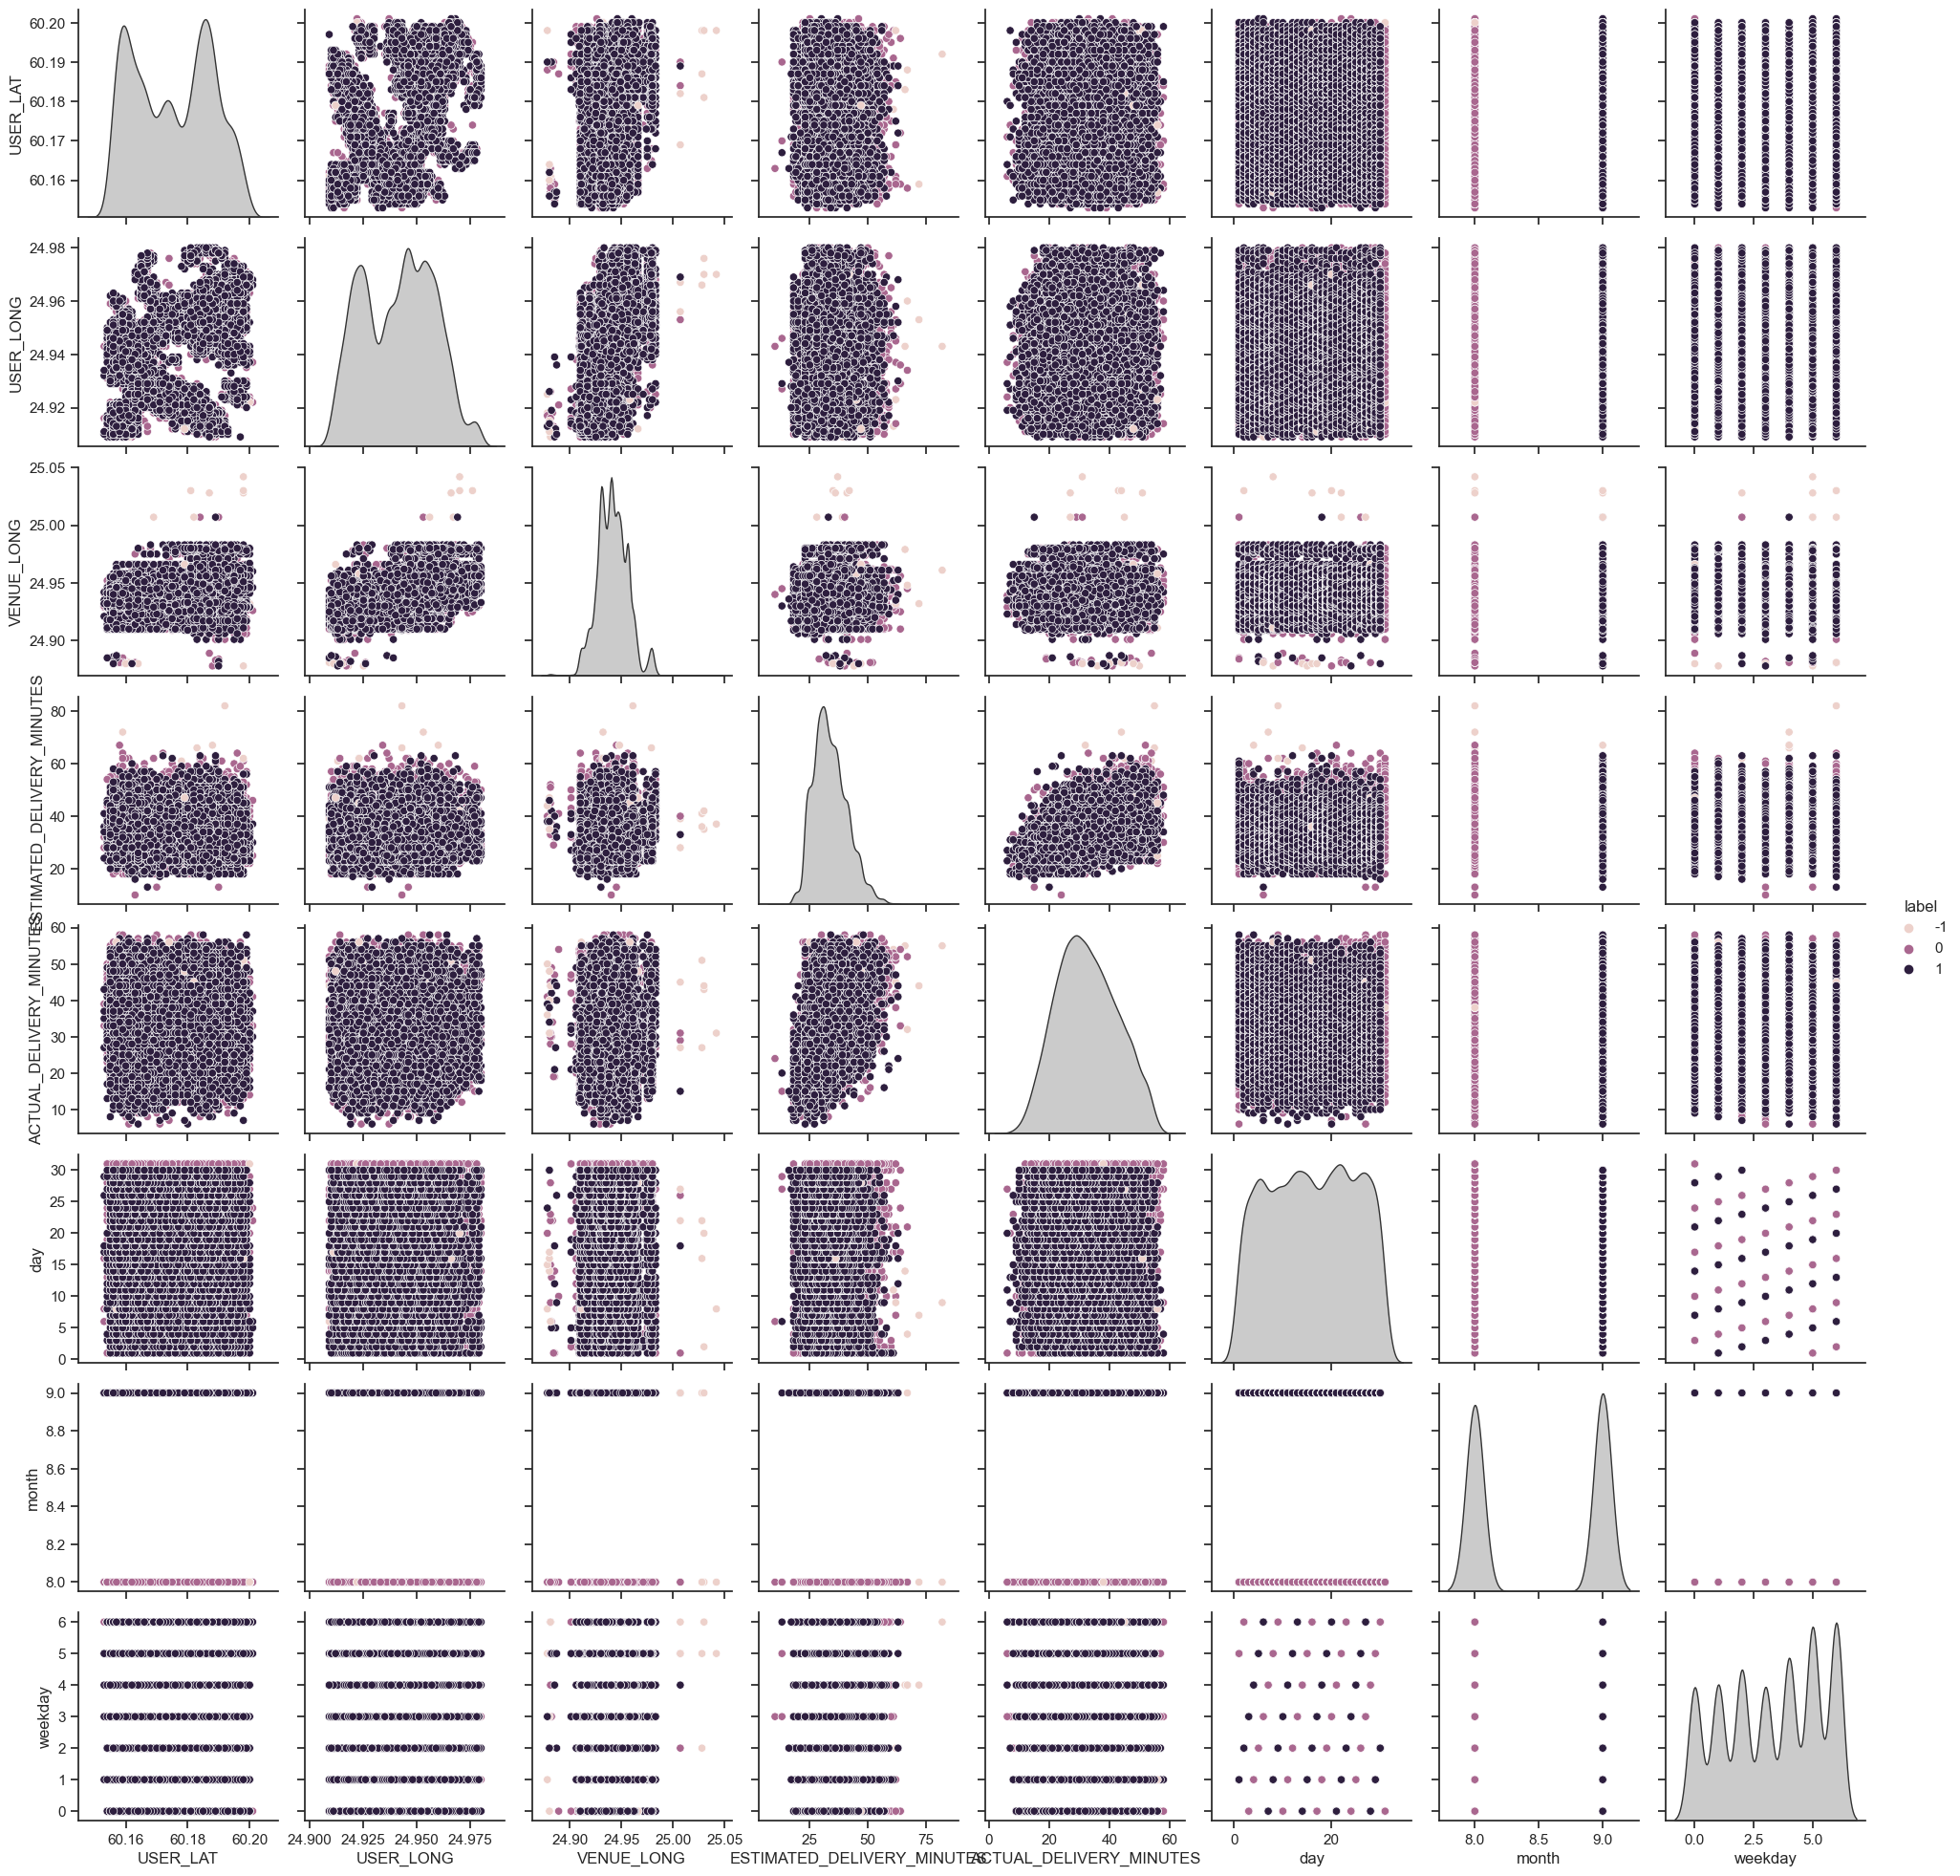

In [27]:
sns.set_theme(style="ticks")

sns.pairplot(pairplot_df, hue="label", diag_kws={"hue": None, "color": ".2"})

Unfortunately, since we did simply two several clear clusters, we cannot say anything about the relationship between location and delivery time, but we see the distribution of data that users are scattered much wider over the same distance as establishments, and this may indicate that establishments may be under quite heavy loads, and that it is not surprising that our expected and actual delivery times do not coincide

### Clasterization conclusion

Very often, the expected delivery time is set automatically, with a reserve for the establishment’s heavy workload, lack of couriers or bad weather conditions for delivery, while the client may be a couple of houses away from the establishment. Then it turns out that we have a pleasant surprise for the user who gets the order arrival earlier - the user is happy, orders more food, Wolt receives more commission from orders, the restaurant continues to cooperate with Wolt - money goes into the system, everyone is happy

## Prediction of the item's amount

Let's assume that it is important for us to predict the number of items made in orders.
Let's do this using two methods: by Random Forest and by Gradient Boosting

### Random Forest

In [28]:
orders_df = orders_df.dropna(axis=0)
# Choose target and features
y = orders_df.ITEM_COUNT
orders_features = ['USER_LAT', 'USER_LONG', 'VENUE_LAT', 'VENUE_LONG', 'ESTIMATED_DELIVERY_MINUTES',
                   'TEMPERATURE', 'WIND_SPEED', 'day', 'month', 'weekday']
X = orders_df[orders_features]

# split data into training and validation data, for both features and target.
# The split is based on a random number generator. Supplying a numeric value to
# the random_state argument guarantees we get the same split every time we run this script.
train_X, val_X, train_y, val_y = train_test_split(X, y,random_state = 0)

Here and below I use client and venue coordinates, estimated delivery time and two of weather descriptions attempting to predict amount of items in customer's basket. I don't use actual delivery time because it's like looking in the future, and I try to model predictions with portion of unknown information

In [29]:
forest_model = RandomForestRegressor(random_state=1)
forest_model.fit(train_X, train_y)
orders_preds = forest_model.predict(val_X)
print(mean_absolute_error(val_y, orders_preds))

1.5175217013888889


Mean Absolute Error - basic, but not perfect metric for modelling evaluation, so I will take R-squared score for getting better precision

In [30]:
r2_score(val_y, orders_preds)

0.05232679188349276

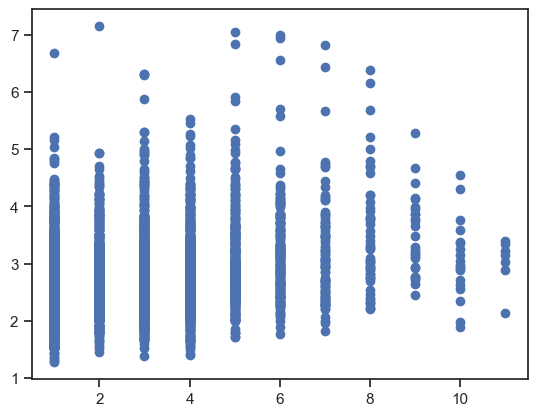

In [31]:
plt.scatter(val_y, orders_preds)

0.05 quite low score for R-squared metric and also we getting float, not discrete values as we see on our prediction diagram

### Gradient Boosting

We started XGBoost modelling with basic parameters, and it gives us even worse score than Random Forest. Let's try to tune our model and try to catch the difference

In [32]:
orders_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
orders_model.fit(train_X, train_y,
            #  early_stopping_rounds=5,
            #  eval_set=[(val_X, val_y)],
             verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [33]:
y_pred = orders_model.predict(val_X)

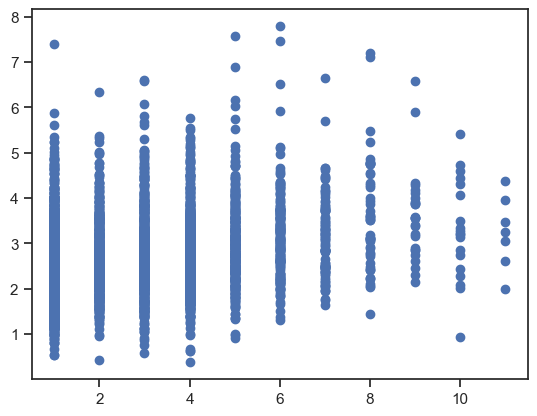

In [34]:
plt.scatter(val_y, y_pred)

In [35]:
print("Mean Absolute Error: " + str(mean_absolute_error(val_y, y_pred)))

Mean Absolute Error: 1.507620481612523


In [36]:
r2_score(val_y, y_pred)

0.030667366832384912

Now we got much better R-squred score and more defined item amounts values despite their imperfectness

As we don't know which exact cost of the order by ampunt of items, assume that 2 items in an order is small order and 3 and more is big and profitable

Let's make binary classification by the criteria of items' amount

In [37]:
orders_df['ITEM_COUNT_type'] = orders_df['ITEM_COUNT'].apply(lambda x: 0 if x < 3 else 1)

In [38]:
orders_df.groupby('ITEM_COUNT_type').count().iloc[:,:1]

TIMESTAMP
ITEM_COUNT_type           
0                     9886
1                     8543

In [39]:
orders_df = orders_df.dropna(axis=0)
# Choose target and features
y_clas = orders_df.ITEM_COUNT_type
orders_features = ['USER_LAT', 'USER_LONG', 'VENUE_LAT', 'VENUE_LONG', 'ESTIMATED_DELIVERY_MINUTES',
                   'TEMPERATURE', 'WIND_SPEED', 'day', 'month', 'weekday']
X_clas = orders_df[orders_features]

# split data into training and validation data, for both features and target.
# The split is based on a random number generator. Supplying a numeric value to
# the random_state argument guarantees we get the same split every time we run this script.
train_X_clas, val_X_clas, train_y_clas, val_y_clas = train_test_split(X_clas, y_clas,random_state = 0)

In [40]:
from xgboost import XGBClassifier

# Create an instance of the XGBClassifier
model = XGBClassifier(objective='binary:logistic', n_estimators=1000, learning_rate=0.05, depth=4)

# Fit the model to the training data
model.fit(train_X_clas, train_y_clas)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, depth=4, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, ...)

In [41]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
y_pred_clas = model.predict(val_X_clas)

print("Precision:", precision_score(val_y_clas, y_pred_clas))
print("Recall:", recall_score(val_y_clas, y_pred_clas))
print("F1-Score:", f1_score(val_y_clas, y_pred_clas))

Precision: 0.5679824561403509
Recall: 0.47763946519133244
F1-Score: 0.5189080891560232


In [42]:
confusion_matrix(val_y_clas, y_pred_clas)

array([[1651,  788],
       [1133, 1036]], dtype=int64)

Precision, Recall and F1-score metrics here much better than in regression modelling, so we can say that Gradient Boosting with classifier predicts item's amount in a client's basket better than other approaches

### Modelling conclusion

Tuned gradient boosting gives us better scores and predictions than any other machine learning method and describes pretty similarly the amount of possibly ordered items. Perhaps, it's better to have more data to make more accurate predictions

### What may I improve and suggest for future analysis?

First of all - visualization. For example, my second correlation diagram is overloaded with data, and it should be better for reding and understanding

Second - I don't use any geotools in Python to get more understanding about clientss and venues' distributions, for example, to make something more similar to heatmap and to make conclusions where do we already have enough partners and where can we suggest to open new businesses or to broad our delivery zone

Third - I may use more data, for example, to predict amount of couriers able to go to work, approximately which coukd us give better understanding about Wolt workforce loading. For example, we know nothing about money customers spend on their orders, and that information is totally valuable for business. So, let's continue analysing by using second dataset

## Daily activity analysis

In [43]:
df = pd.read_csv('daily_cp_activity_dataset.csv')
df

date  courier_partners_online  temperature  relative_humidity  \
0    2021-05-01                       49        18.27               0.57   
1    2021-05-02                      927        19.88               0.55   
2    2021-05-03                       40        16.88               0.60   
3    2021-05-04                       51        21.88               0.53   
4    2021-05-05                       50        21.11               0.54   
..          ...                      ...          ...                ...   
756  2023-05-27                       70        19.22               0.56   
757  2023-05-28                       76        27.26               0.64   
758  2023-05-29                       73          NaN               0.62   
759  2023-05-30                       81        18.35               0.57   
760  2023-05-31                       76        15.56               0.62   

     precipitation  
0             0.00  
1             0.00  
2             0.00  
3             0.00  
4             0.00  
..             ...  
756           0.00  
757           0.41  
758           0.80  
759           0.00  
760           1.16  

[761 rows x 5 columns]

In [44]:
df.describe()

courier_partners_online  temperature  relative_humidity  precipitation
count               761.000000   731.000000         761.000000     756.000000
mean                 72.417871    17.532585           0.653193       0.914735
std                  96.039679    10.007564           0.171553       1.749988
min                  34.000000    -9.980000           0.430000       0.000000
25%                  58.000000    10.930000           0.520000       0.000000
50%                  66.000000    18.630000           0.590000       0.000000
75%                  72.000000    24.410000           0.790000       0.910000
max                1506.000000    37.950000           1.000000      12.900000

In [45]:
df['date'] = pd.to_datetime(df['date'])
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['weekday'] = df['date'].dt.day_of_week

In [46]:
corr = abs(df.corr())
corr.style.background_gradient(cmap="Blues", axis=1)\
    .format(precision=1)

We see correlation among weather condition's parameters and also between weather conditions and months

### Counting amount of couriers

Let's make data distribution for date, number of couriers online

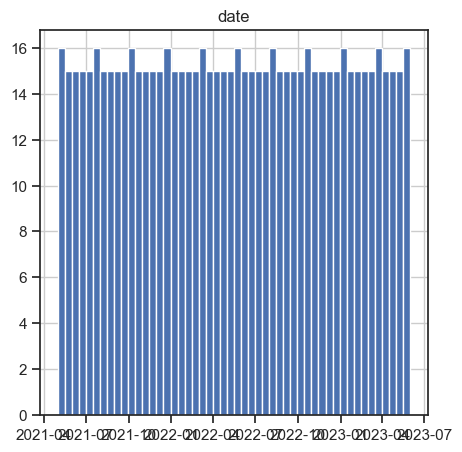

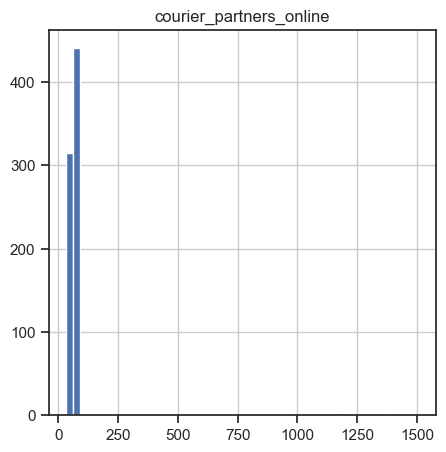

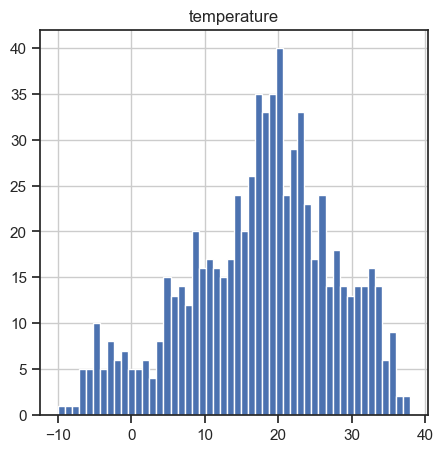

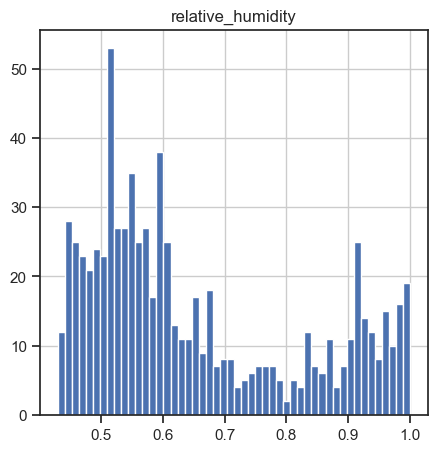

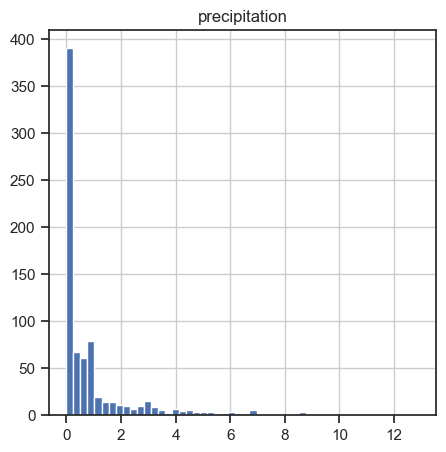

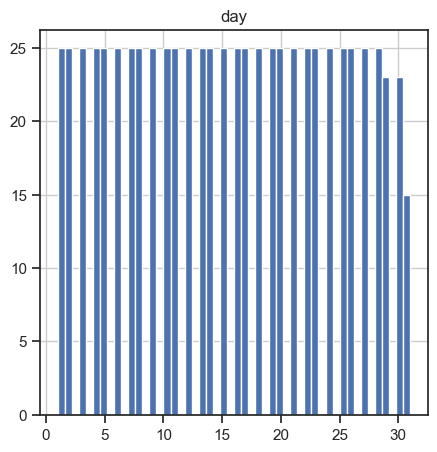

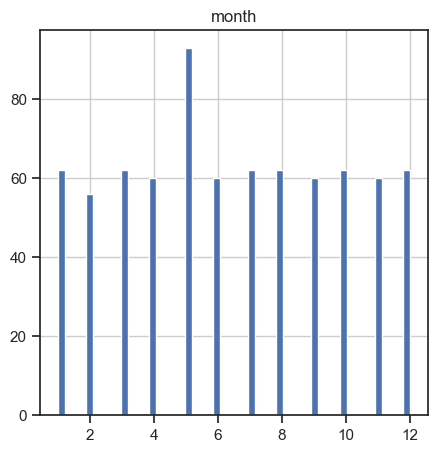

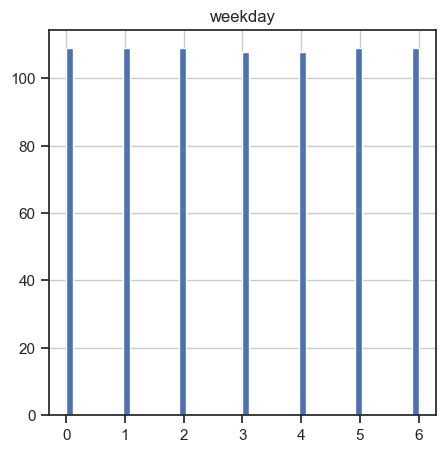

In [47]:
for col_name in df.columns:
  plt.figure(figsize=(5,5))
  df[col_name].hist(bins=50)
  plt.title(col_name)

We have some peaks by couriers' amount online, let's take a look more propely

In [48]:
df.query('courier_partners_online > 250')

date  courier_partners_online  temperature  relative_humidity  \
1   2021-05-02                      927        19.88               0.55   
138 2021-09-16                     1367        30.68               0.46   
269 2022-01-25                     1176        -2.61               0.92   
326 2022-03-23                     1506          NaN               0.55   
635 2023-01-26                     1175        -1.88               0.92   

     precipitation  day  month  weekday  
1             0.00    2      5        6  
138           0.00   16      9        3  
269           0.84   25      1        1  
326           0.00   23      3        2  
635           0.85   26      1        3

These peaks are not so many, thefore drop them and weather NaNs

In [49]:
df = df.query('courier_partners_online < 250').dropna()

<Axes: >

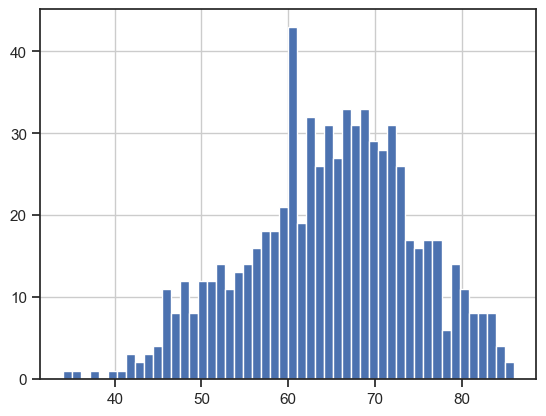

In [50]:
df['courier_partners_online'].hist(bins=50)

As we see at histogram, couriers distribution is close to normal distribution. Implement feature "courier_num" to show quality estimate amount of couriers

In [51]:
def courier_num(n):
  if n < 60:
    return 0
  elif n < 75:
    return 1
  else:
    return 2
df['courier_num'] = df['courier_partners_online'].apply(lambda x: courier_num(x))

Regression prognose of courier amount

In [52]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['courier_partners_online', 'courier_num', 'date']), 
                                                    df['courier_partners_online'], random_state = 0, stratify=df['weekday'])

In [53]:
X_train

temperature  relative_humidity  precipitation  day  month  weekday
181        28.90               0.47           0.00   29     10        4
624        -7.07               0.94           8.52   15      1        6
372        17.26               0.59           0.00    8      5        6
37         12.20               0.71           0.87    7      6        0
606         7.71               0.87           3.04   28     12        2
..           ...                ...            ...  ...    ...      ...
339        20.17               0.55           0.00    5      4        1
292         7.11               0.90           0.84   17      2        3
419        13.79               0.81           0.65   24      6        4
158        32.31               0.45           0.00    6     10        2
196        20.17               0.55           0.00   13     11        5

[541 rows x 6 columns]

In [54]:
couriers_model = XGBRegressor(n_estimators=1000, learning_rate=0.05, depth=4)
couriers_model.fit(X_train, y_train,
             verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, depth=4, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [55]:
y_pred = couriers_model.predict(X_test)

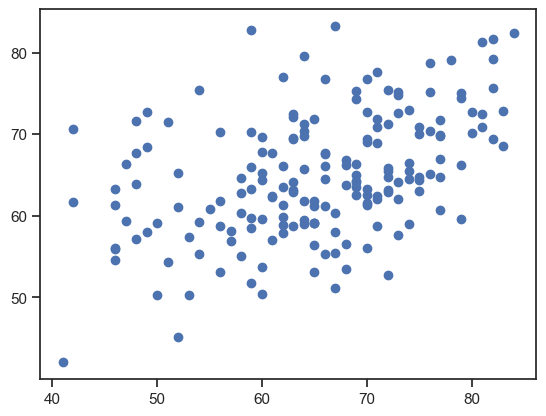

In [56]:
plt.scatter(y_test, y_pred)

In [57]:
print("Mean Absolute Error: " + str(mean_absolute_error(y_test, y_pred)))

Mean Absolute Error: 7.395893750269769


In [58]:
r2_score(y_test, y_pred)

0.09146973580024631

These metrics scores are not satisfying for us, so let's try to make multiclass classification and predict approximate amount of couriers

In [59]:
import xgboost as xgb

In [61]:
X_train_clas, X_test_clas, y_train_clas, y_test_clas = train_test_split(df.drop(columns=['courier_partners_online', 'courier_num', 'date']), df['courier_num'], random_state = 0, stratify=df['weekday'])

In [62]:
## ---------- XGBoost model v2 ----------
## second run of model with "optimized" hyperparameters
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import balanced_accuracy_score, accuracy_score, precision_score, recall_score, f1_score

# declaring and fitting xgb classifier
xgb_clf = xgb.XGBClassifier(objective='multi:softmax',
                            n_estimators=500,
                            num_class=3,
                            learning_rate=0.01,
                            max_depth=4,
                            seed=42)
xgb_clf.fit(X_train_clas,
            y_train_clas,
            verbose=0)

## ---------- Model Classification Report ----------
## get predictions and create model quality report

y_pred = xgb_clf.predict(X_test_clas)

print('\n------------------ Confusion Matrix -----------------\n')
print(confusion_matrix(y_test_clas, y_pred))

print('\nAccuracy: {:.2f}'.format(accuracy_score(y_test_clas, y_pred)))
print('Balanced Accuracy: {:.2f}\n'.format(balanced_accuracy_score(y_test_clas, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test_clas, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test_clas, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test_clas, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test_clas, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test_clas, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test_clas, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test_clas, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test_clas, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test_clas, y_pred, average='weighted')))

print('\n--------------- Classification Report ---------------\n')
print(classification_report(y_test_clas, y_pred))
print('---------------------- XGBoost ----------------------') # unnecessary fancy styling


------------------ Confusion Matrix -----------------

[[21 22  4]
 [16 76 10]
 [ 0 20 12]]

Accuracy: 0.60
Balanced Accuracy: 0.52

Micro Precision: 0.60
Micro Recall: 0.60
Micro F1-score: 0.60

Macro Precision: 0.56
Macro Recall: 0.52
Macro F1-score: 0.53

Weighted Precision: 0.59
Weighted Recall: 0.60
Weighted F1-score: 0.59

--------------- Classification Report ---------------

              precision    recall  f1-score   support

           0       0.57      0.45      0.50        47
           1       0.64      0.75      0.69       102
           2       0.46      0.38      0.41        32

    accuracy                           0.60       181
   macro avg       0.56      0.52      0.53       181
weighted avg       0.59      0.60      0.59       181

---------------------- XGBoost ----------------------


We see decent metrics by every class. If we add more parameters, model's quality would be better

### Feature importance

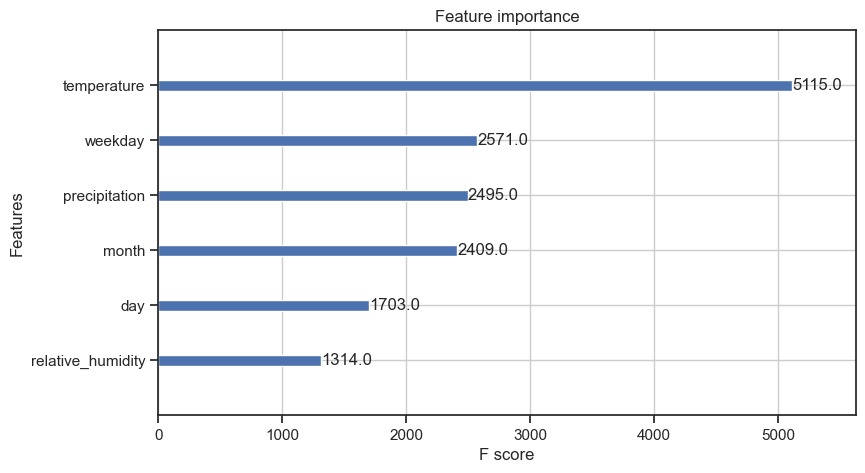

In [63]:
## ---------- Plot Feature Importance ----------

from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(9,5))
plot_importance(xgb_clf, ax=ax)
plt.show()

First of all, temerature matters, second important feature is day of the week and air humidity make less sense among all features

For any questions, please contact me by linkedin https://www.linkedin.com/in/anastasiiamurashova/ or email - anastasiiamurashova@gmail.com
    